In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# import joblib
# sys.modules['sklearn.externals.joblib'] = joblib
# from sklearn.preprocessing import Imputer
# sys.modules['sklearn.preprocessing.Imputer'] = Imputer
from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [2]:
def power_spectral_density_RCLfit(freq):
    r"""
    Return the effective power spectral density (PSD) of the detector noise
    at a given frequency, according to the analytical fit by Robson, Cornish
    and Liu, :arxiv:`1803.01944`

    INPUT:

    - ``freq`` -- frequency `f` (in `\mathrm{Hz}`)

    OUTPUT:

    - effective power spectral density `S(f)` (in `\mathrm{Hz}^{-1}`)

    EXAMPLES::

        sage: from kerrgeodesic_gw import lisa_detector
        sage: Sn = lisa_detector.power_spectral_density_RCLfit
        sage: Sn(1.e-1)  # tol 1.0e-13
        2.12858262120861e-39
        sage: Sn(1.e-2)  # tol 1.0e-13
        1.44307343517977e-40
        sage: Sn(1.e-3)  # tol 1.0e-13
        1.63410027259543e-38

    """
    p_oms = 2.25e-22 * (1 + (2.e-3/freq)**4)
    p_acc = 9.e-30 * (1 +(4.e-4/freq)**2) * (1 + (freq/8.e-3)**4)
    L = 2.5e9
    f_star = 1.909e-2
    p_n = (p_oms + 2*(1 + np.cos(freq/f_star)**2)*p_acc/(2*(np.pi)*freq)**4)/L**2
    return 10./3.*p_n*(1 + 0.6*(freq/f_star)**2)

In [3]:
use_gpu = True

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp 
def calculate_signalMod(r, L,e0):
    wave = few(M, mu, r, e0, theta, phi, dist=dist1, dt=dt, T=L)
    fft_plus = cp.fft.fft(wave.real)
    fft_corss = cp.fft.fft(wave.imag)
    power_spectrum_real = cp.abs(fft_plus) ** 2
    power_spectrum_imag = cp.abs(fft_corss) ** 2
    power_spectrum = power_spectrum_real + power_spectrum_imag
    return power_spectrum
    
def calculate_snr_profile(r_values, mu, T,e0):
    snr = []
    for r_val in r_values:
        signal_to = calculate_signalMod(r_val, 1/365,e0) 
        freq = np.logspace(-5, 0, len(signal_to))
        psd = power_spectral_density_RCLfit(freq)  # # I want a set of plot for variing theta  with same eccentricity then plot the fourier transform by its side  
# # Define eccentricities
# eccentricities = np.linspace(0, 0.4, 5)
#  theta = 0 m pi/2*mpi/4
        sum_temp = cp.sum(templ)
        snr.append(cp.sqrt(sum_temp).get())  # Retrieve result from GPU and append to list
    return snr

def plot_snr_profile(r_values, snr_values, mu, T,e0):
    plt.figure()
    plt.plot(r_values, snr_values, '.')
    # Plot best fit line here if needed
    plt.xlabel('r')
    plt.title(f'SNR Profile for T = {T} years')
    plt.show()




In [5]:
# This block of code is setting up the initial conditions for generating a gravitational waveform.


M = 4.15e6 # mass of the black hole in solar masses
mu = 5e-2 # mass of the compact object in solar masses
dist1 = 0.000008277 # distance to the source in gigaparsecs
e0 = 0.0 # initial eccentricity
theta = np.pi / 2  # polar viewing angle
phi = 0  # azimuthal viewing angle
dt = 15 # time step in seconds
p0 = 9 # initial semilatus rectum in this case our orbit is circular. thus p =r = 6.15. 
t0 = 0.0 # initial time
T=0.000114155 # total time in years to generate the waveform here i take 1hr
wave = few(M, mu, p0, e0, theta, phi, dist=dist1, dt=dt, T=T) # generate the waveform

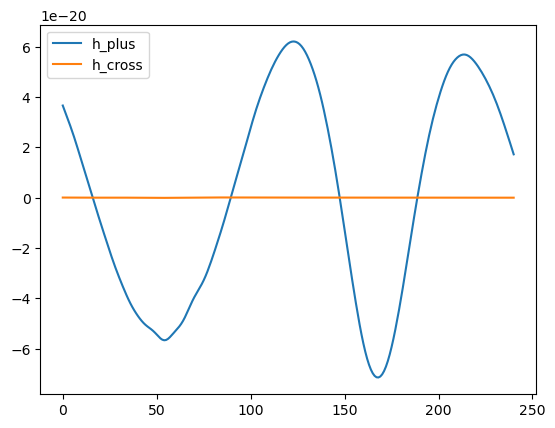

In [6]:
# plot waveform
plt.figure()
plt.plot(wave.real.get(), label='h_plus')
plt.plot(wave.imag.get(), label='h_cross')
plt.legend()
plt.show()


In this note book we will look into the change of the eccentricity and how the waveform changes.    

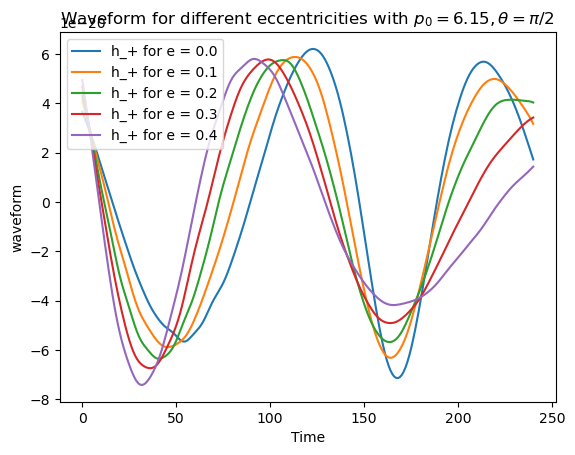

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define eccentricities
eccentricities = np.linspace(0, 0.4, 5)

# Generate waveforms and store them in a list
waveforms = []
for e in eccentricities:
    wave = few(M, mu, p0, e, theta, phi, dist=dist1, dt=dt, T=1/(365*24))
    waveforms.append(wave)

# Plot all waveforms
plt.figure()
for i, wave in enumerate(waveforms):
    plt.plot(wave.real.get(), label=r'h_+ for e = {:.1f}'.format(eccentricities[i]))
    # plt.plot(wave.imag.get(), label='h_x for e = {:.1f}'.format(eccentricities[i]))
plt.title(r'Waveform for different eccentricities with $p_0 = 6.15, \theta=\pi/2 $')
plt.xlabel('Time')
plt.ylabel('waveform')
plt.legend()
plt.show()



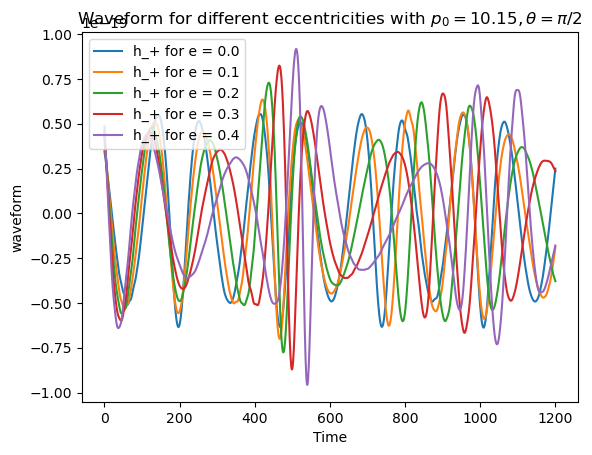

In [8]:
# Define eccentricities
eccentricities = np.linspace(0, 0.4, 5)

# Generate waveforms and store them in a list
waveforms = []
for e in eccentricities:
    wave = few(M, mu, 10, e, theta, phi, dist=dist1, dt=dt, T=5/(365*24))
    waveforms.append(wave)

# Plot all waveforms
plt.figure()
for i, wave in enumerate(waveforms):
    plt.plot(wave.real.get(), label=r'h_+ for e = {:.1f}'.format(eccentricities[i]))
    # plt.plot(wave.imag.get(), label='h_x for e = {:.1f}'.format(eccentricities[i]))
plt.title(r'Waveform for different eccentricities with $p_0 = 10.15, \theta=\pi/2 $')
plt.xlabel('Time')
plt.ylabel('waveform')
plt.legend()
plt.show()


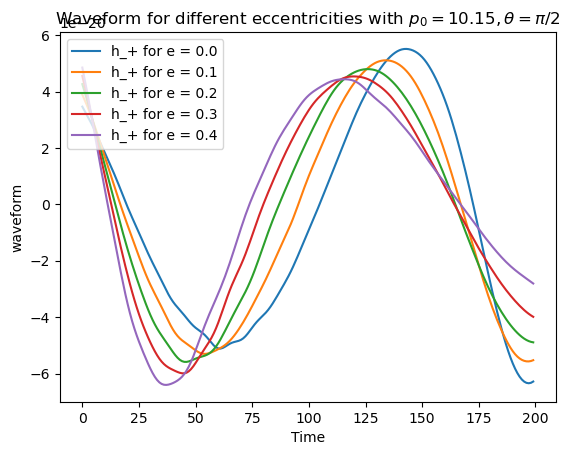

In [9]:
plt.figure()
for i, wave in enumerate(waveforms):
    plt.plot(wave.real[:200].get(), label=r'h_+ for e = {:.1f}'.format(eccentricities[i]))
    # plt.plot(wave.imag.get(), label='h_x for e = {:.1f}'.format(eccentricities[i]))
plt.title(r'Waveform for different eccentricities with $p_0 = 10.15, \theta=\pi/2 $')
plt.xlabel('Time')
plt.ylabel('waveform')
plt.legend()
plt.show()


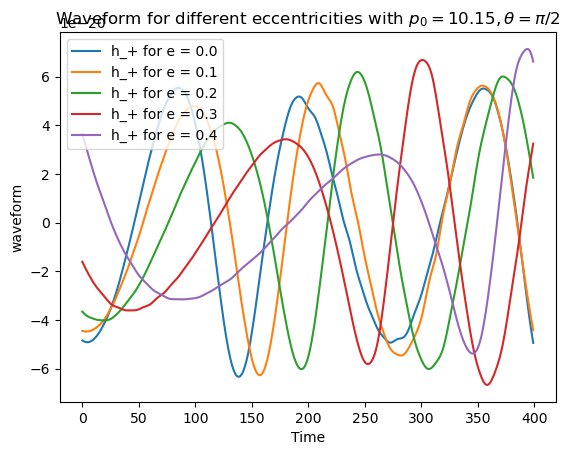

In [10]:
plt.figure()
for i, wave in enumerate(waveforms):
    plt.plot(wave.real[600:1000].get(), label=r'h_+ for e = {:.1f}'.format(eccentricities[i]))
    # plt.plot(wave.imag.get(), label='h_x for e = {:.1f}'.format(eccentricities[i]))
plt.title(r'Waveform for different eccentricities with $p_0 = 10.15, \theta=\pi/2 $')
plt.xlabel('Time')
plt.ylabel('waveform')
plt.legend()
plt.show()


In [11]:
# i want to calculate snr for different values of e as r goes from 9 to 16.
# # i want to store them in a list and plot them in a graph.
# snr_valuesl = []

# for e in eccentricities:
#     r_values = np.linspace(9, 16, 10)
#     for r_val in range(len(r_values)):
#         snr_values = calculate_snr_profile(r_val, mu, T,e)
#         snr_valuesl.append(snr_values)
# # Plot all snr values in a single graph with different colors and legends as e changes
# plt.figure()
# for i, snr_values in enumerate(snr_valuesl):
#     plt.plot(r_values, snr_values, label=r'SNR for e = {:.1f}'.format(eccentricities[i]))
# plt.legend()
# plt.show()

    

In [13]:
# snr_valuesl = []
# templ = []

# for e in eccentricities:
#     r_values = np.linspace(9, 16, 10)
#     snr_values = calculate_snr_profile(r_values, mu, T, e)
#     snr_valuesl.append(snr_values)

# # Plot all snr values in a single graph with different colors and legends as e changes
# plt.figure()
# for i, snr_values in enumerate(snr_valuesl):
#     plt.plot(r_values, snr_values, label=r'e = {:.1f}'.format(eccentricities[i]))
# plt.xlabel('r')
# plt.ylabel('SNR')
# plt.legend()
# plt.show()



In [15]:


# p0=10

# eccentricities = np.linspace(0, 0.75,20)
# snr_values = []

# for e in eccentricities:
#     r_values = np.linspace(10, 16, 10)
#     snr_values = calculate_snr_profile(r_values, mu, T, e)
#     snr_values.append(snr_values)



No handles with labels found to put in legend.


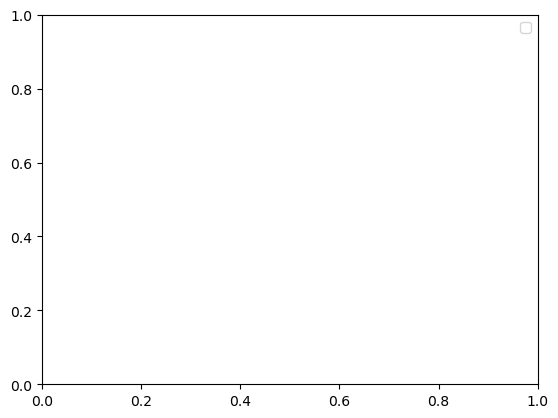

In [16]:
plt.figure()
for i, snr_values in enumerate(snr_valuesl):
    plt.plot(r_values, snr_values,  label=r'SNR for e = {:.1f}'.format(eccentricities[i]))
plt.legend()
plt.show()

In [18]:
# # # I want a set of plot for variing theta  with same eccentricity then plot the fourier transform by its side  
# # # Define eccentricities
# dt=10
# # eccentricities = np.linspace(0, 0.4, 5)
# import numpy as np
# import matplotlib.pyplot as plt

# # Define eccentricity
# eccentricity = 0.4
# p0=10

# # Define theta values
# theta_values = [0, np.pi/2, np.pi/4]

# # Define Fourier transform function


# def fourier_transform(data):
#     dt =10
#     # make sure data time and frequency are in the same size
#     N = len(data)
#     t= np.arange(len(data)) * dt  # time array
#     dt = t[1] - t[0]
#     freq = np.fft.fftfreq(N, dt)
#     fft_data = np.fft.fft(data)
#     return freq, fft_data

# # Generate plots for each theta value
# for theta in theta_values:
#     # Generate data for the plot
#     t= np.arange(len(wave)) * dt  # time array

#         # data = np.sin(2 * np.pi * t + theta)
#     data = few(M, mu, p0, eccentricity, theta, phi, dist=dist1, dt=dt, T=1/(365).real).get()
#     datax = few(M, mu, p0, eccentricity, theta, phi, dist=dist1, dt=dt, T=1/(365).imag).get()
#     N=len(data)
#     # Calculate Fourier transform
#     dt= t[1] - t[0] 
#     freq, fft_data = fourier_transform(data)
#     freqx, fft_datax = fourier_transform(datax)

#     # Plot the data and Fourier transform
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#     ax1.plot( datax, label=r'$ h_{+} $')
#     ax1.plot( data, label=r'$ h_{x} $')
#     ax1.set_xlabel('Time')
#     ax1.set_ylabel('Amplitude')
#     ax1.set_title(f'Theta = {theta:.2f}')

#       # Plot only the positive frequencies up to the x value of 0.1
#     ax2.plot(freqx[:N//2], np.abs(fft_datax[:N//2]) , label=r'$ h_{x} $')
#     ax2.plot(freq[:N//2], np.abs(fft_data[:N//2]), label=r'$ h_{+} $' )
#     ax2.set_xlabel('Frequency')
#     ax2.set_ylabel('Amplitude')
#     ax2.set_title('Fourier Transform')

#     plt.tight_layout()
#     plt.show()

In [19]:
def fourier_transform(data):
    dt =10
    # make sure data time and frequency are in the same size
    N = len(data)
    t= np.arange(len(data)) * dt  # time array
    dt = t[1] - t[0]
    freq = np.fft.fftfreq(N, dt)
    fft_data = np.fft.fft(data)
    return freq, fft_data


def limit_freq(freq, fft_data, limit):
    # # # Limit to 0.1 MHz (100 kHz)
# limit_frequency = 1  # 0.1 MHz = 100,000 Hz
# limited_frequencies = frequencies < limit_frequency
# frequencies = frequencies[limited_frequencies]
# H_f = H_f[limited_frequencies]
# positive_frequencies = frequencies > 0
# frequencies = frequencies[positive_frequencies]
# H_f = H_f[positive_frequencies]
    
    positive_frequencies = freq > 0
    freq = freq[positive_frequencies]
    fft_data = fft_data[positive_frequencies]
    limited_frequencies = freq < limit
    freq = freq[limited_frequencies]
    fft_data = fft_data[limited_frequencies]
    return freq, fft_data





def eccentricitiesdependence(e0m,p0):
    # # I want a set of plot for variing theta  with same eccentricity then plot the fourier transform by its side  
    # # Define eccentricities
    dt=1
    # eccentricities = np.linspace(0, 0.4, 5

    # Define eccentricity
    eccentricity = e0m

    # Define theta values
    theta_values = [0, np.pi/2, np.pi/4]

    # Define Fourier transform function



    # Generate plots for each theta value
    for theta in theta_values:
        # Generate data for the plot
        t= np.arange(len(wave)) * dt  # time array

            # data = np.sin(2 * np.pi * t + theta)
        data = few(M, mu, p0, e0m, theta, 0, dist=dist1, dt=dt, T=1/(365*24)).real.get()
        datax = few(M, mu, p0, e0m, theta, 0, dist=dist1, dt=dt, T=1/(365*24)).imag.get()
        N=len(data)
        # Calculate Fourier transform
        dt= t[1] - t[0] 
        freq, fft_data = fourier_transform(data)
        freqx, fft_datax = fourier_transform(datax)

        # Plot the data and Fourier transform
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.plot( datax, label=r'$ h_{+} $')
        ax1.plot( data, label=r'$ h_{x} $')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Amplitude')
        ax1.set_title(f'Theta ={theta:} ,eccentricity = {e0m:}')

        # Plot only the positive frequencies up to the x value of 0.1
        d1,d2=limit_freq(freq, fft_data, 0.0004)
        d1x,d2x=limit_freq(freqx, fft_datax, 0.0004)
        ax2.plot(d1, np.abs(d2) , label=r'$ h_{x} $')
        ax2.plot(d1x, np.abs(d2), label=r'$ h_{+} $' )
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Amplitude')
        ax2.set_title('Fourier Transform')

        plt.tight_layout()
        plt.show()

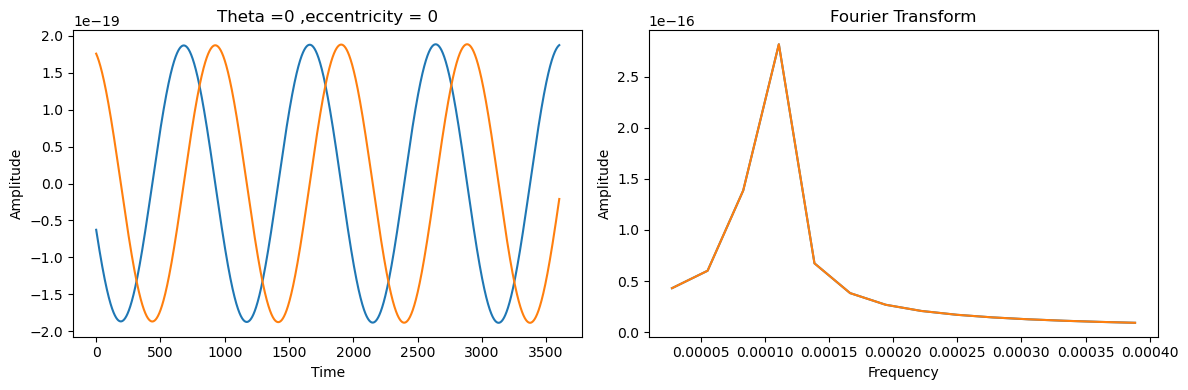

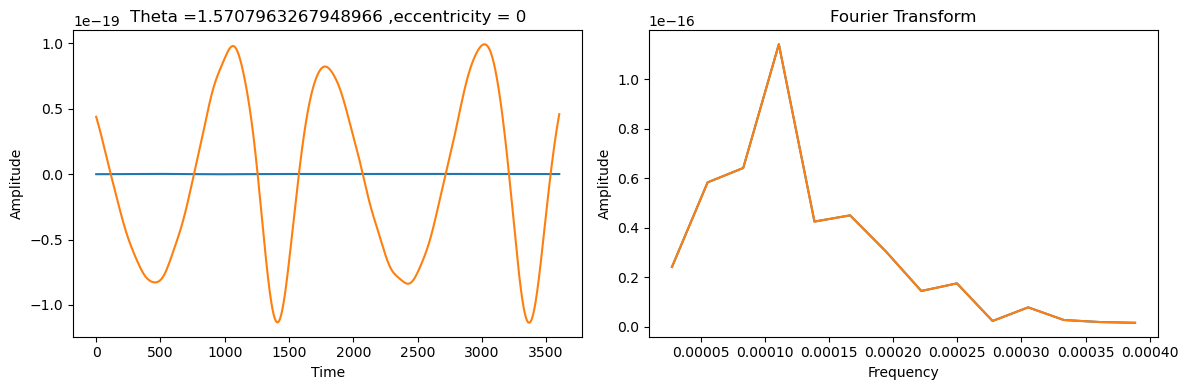

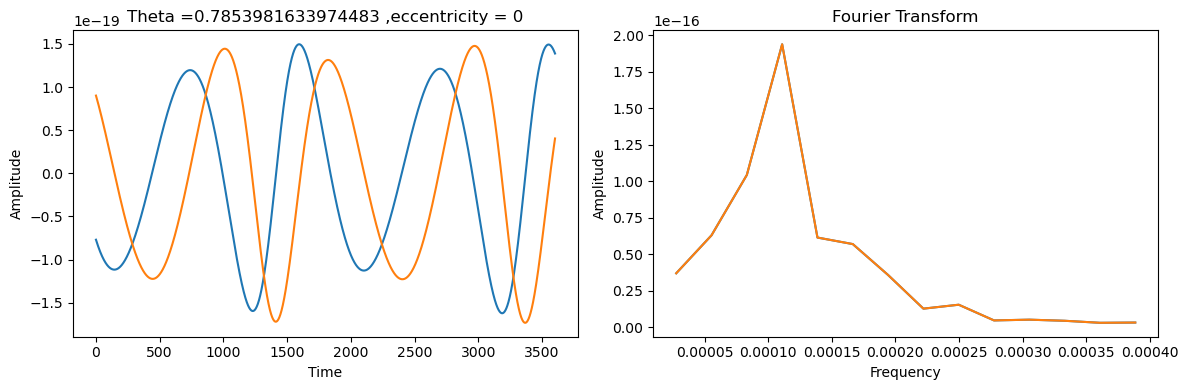

In [ ]:
eccentricitiesdependence(0,6.15)

In [20]:
wave = few(M, mu, 6.15, 0, theta, phi, dist=dist1, dt=dt, T=1/(365*24)) # generate the waveform
# size of wave

def fourier_transform(data):
    dt =10
    # make sure data time and frequency are in the same size
    N = len(data)
    t= np.arange(len(data)) * dt  # time array
    dt = t[1] - t[0]
    freq = np.fft.fftfreq(N, dt)
    fft_data = np.fft.fft(data)
    return freq, fft_data


def limit_freq(freq, fft_data, limit):
    # # # Limit to 0.1 MHz (100 kHz)
# limit_frequency = 1  # 0.1 MHz = 100,000 Hz
# limited_frequencies = frequencies < limit_frequency
# frequencies = frequencies[limited_frequencies]
# H_f = H_f[limited_frequencies]
# positive_frequencies = frequencies > 0
# frequencies = frequencies[positive_frequencies]
# H_f = H_f[positive_frequencies]
    
    positive_frequencies = freq > 0
    freq = freq[positive_frequencies]
    fft_data = fft_data[positive_frequencies]
    limited_frequencies = freq < limit
    freq = freq[limited_frequencies]
    fft_data = fft_data[limited_frequencies]
    return freq, fft_data





def eccentricitiesdependence(e0m,p0,T):
    # # I want a set of plot for variing theta  with same eccentricity then plot the fourier transform by its side  
    # # Define eccentricities
    dt=1
    # eccentricities = np.linspace(0, 0.4, 5

    # Define eccentricity
    eccentricity = e0m

    # Define theta values
    theta_values = [0,  np.pi/4, np.pi/2]

    # Define Fourier transform function



    # Generate plots for each theta value
    for theta in theta_values:
        # Generate data for the plot
        t= np.arange(len(wave)) * dt  # time array

        # data = np.sin(2 * np.pi * t + theta)
        data = few(M, mu, p0, e0m, theta, phi, dist=dist1, dt=dt, T=T).real.get()
        datax = few(M, mu, p0, e0m, theta, phi, dist=dist1, dt=dt, T=T).imag.get()
        N=len(data)
        # Calculate Fourier transform
        dt= t[1] - t[0] 
        freq, fft_data = fourier_transform(data)
        freqx, fft_datax = fourier_transform(datax)

        # Plot the data and Fourier transform
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.plot( datax[:3500], label=r'$ h_{x} $')
        ax1.plot( data[:3500], label=r'$ h_{+} $')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Amplitude')
        ax1.set_title(f'Theta ={theta:} ,eccentricity = {e0m:}')
        ax1.legend()
        # Plot only the positive frequencies up to the x value of 0.1
        d1,d2=limit_freq(freq, fft_data, 0.0004)
        d1x,d2x=limit_freq(freqx, fft_datax, 0.0004)
        ax2.plot(d1, np.abs(d2) , label=r'$ h_{+} $')
        ax2.plot(d1x, np.abs(d2x), label=r'$ h_{x} $' )
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Amplitude')
        ax2.set_title('Fourier Transform')

        ax2.legend()
        plt.tight_layout()
        plt.show()

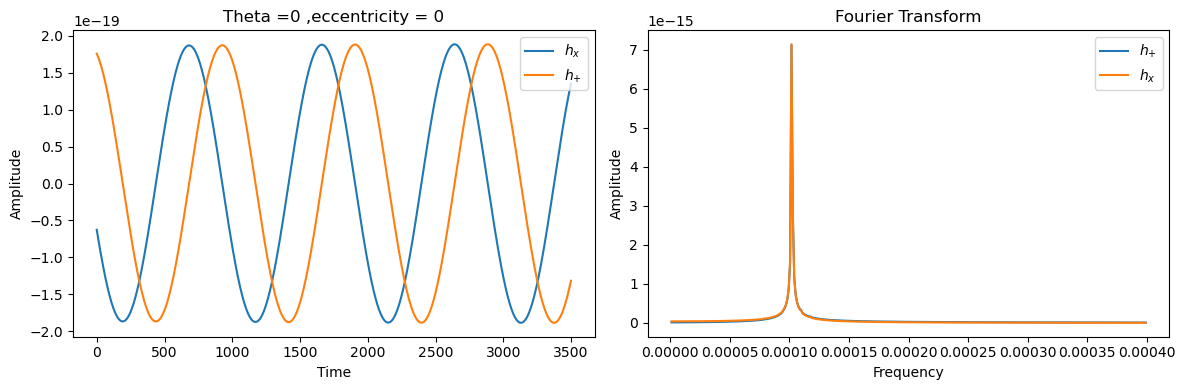

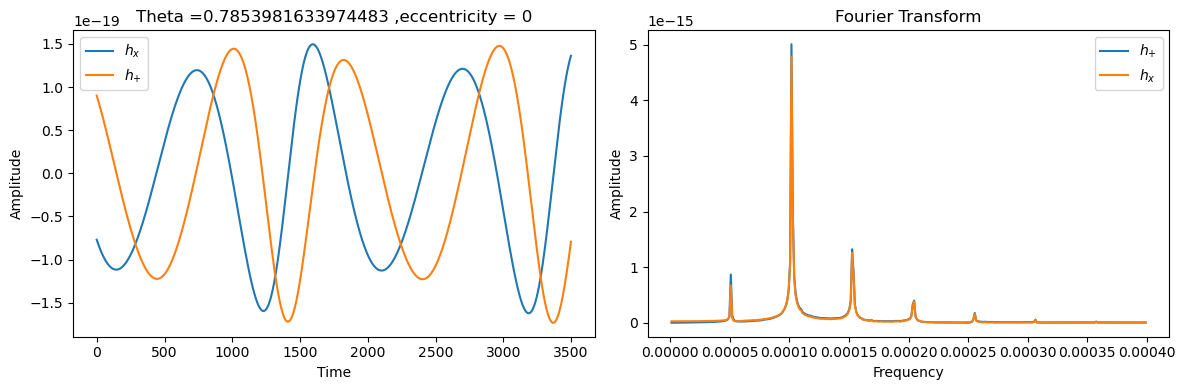

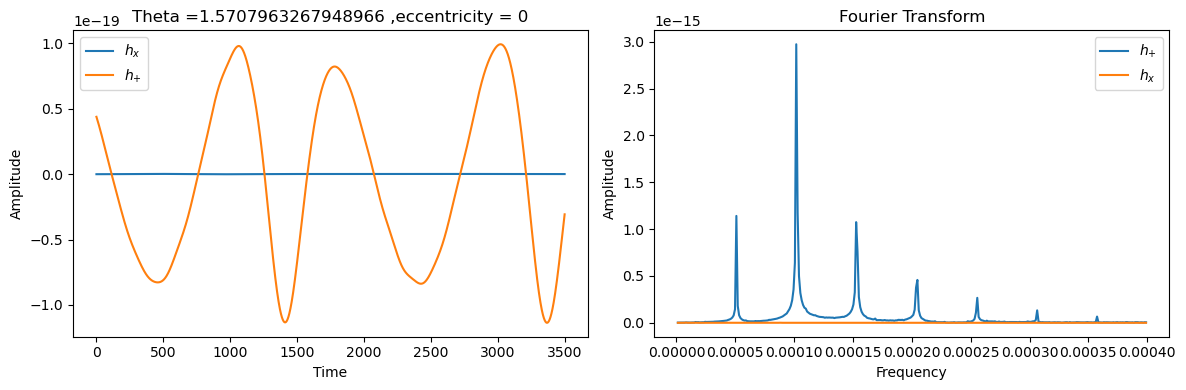

In [ ]:
eccentricitiesdependence(0,6.15,1/365)

0.0027397260273972603


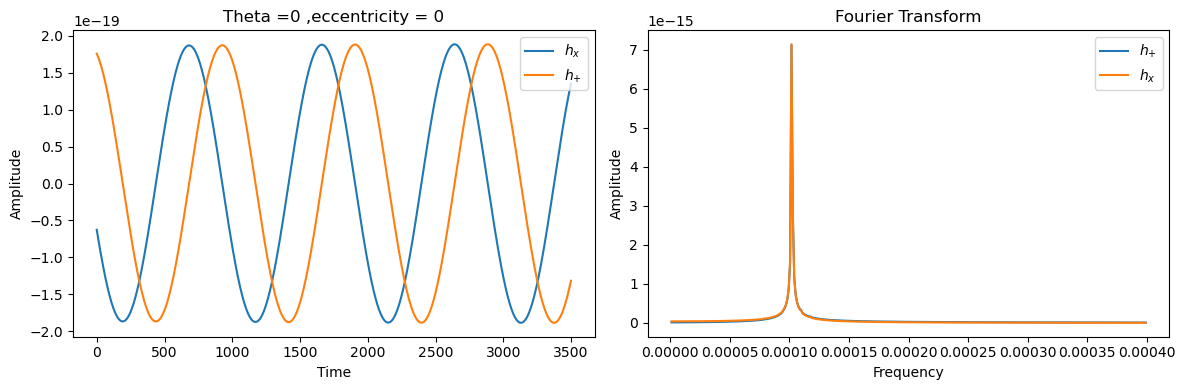

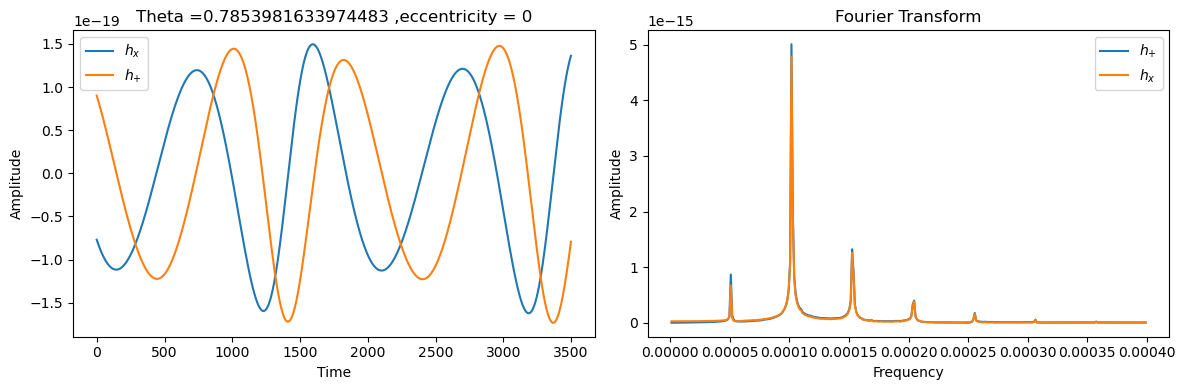

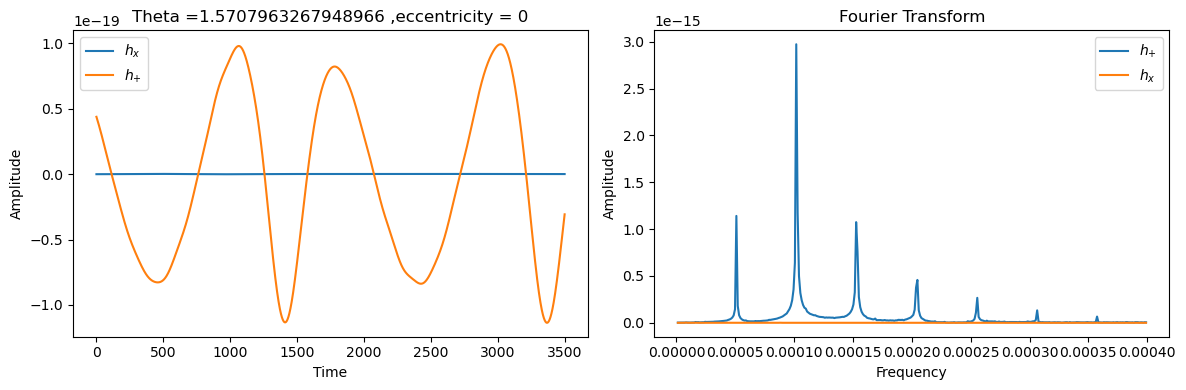

0.5


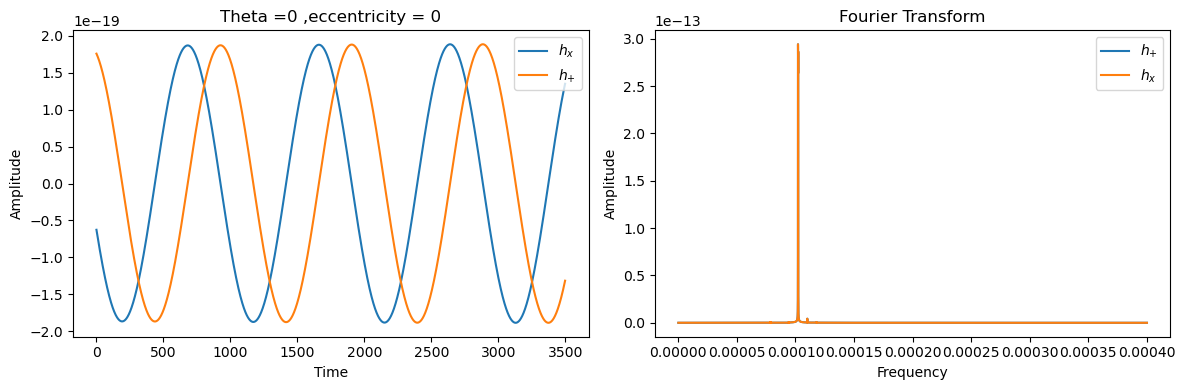

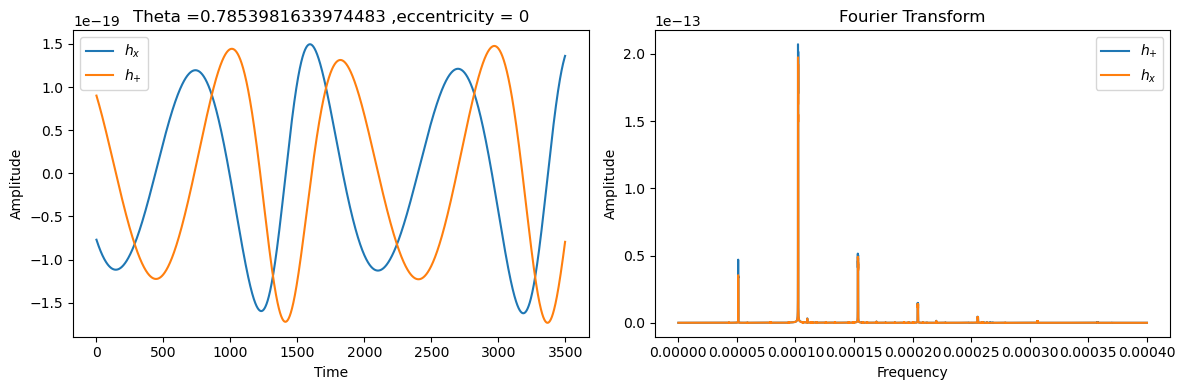

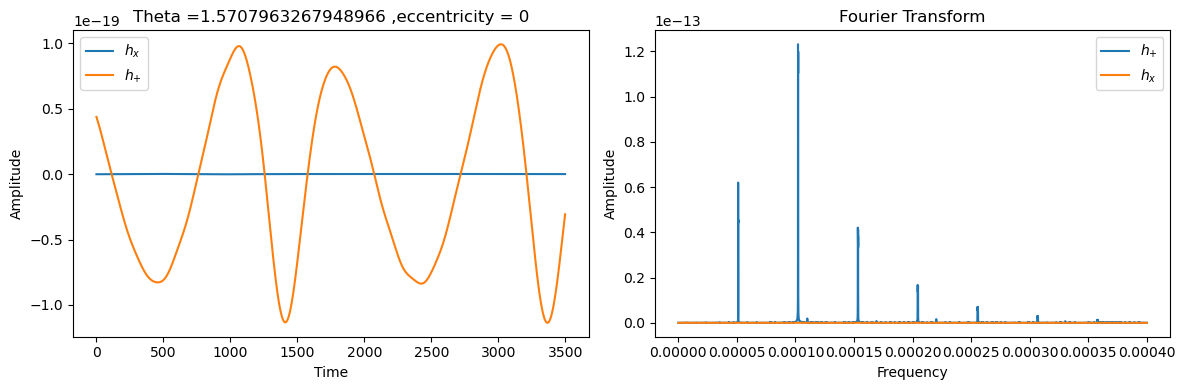

1


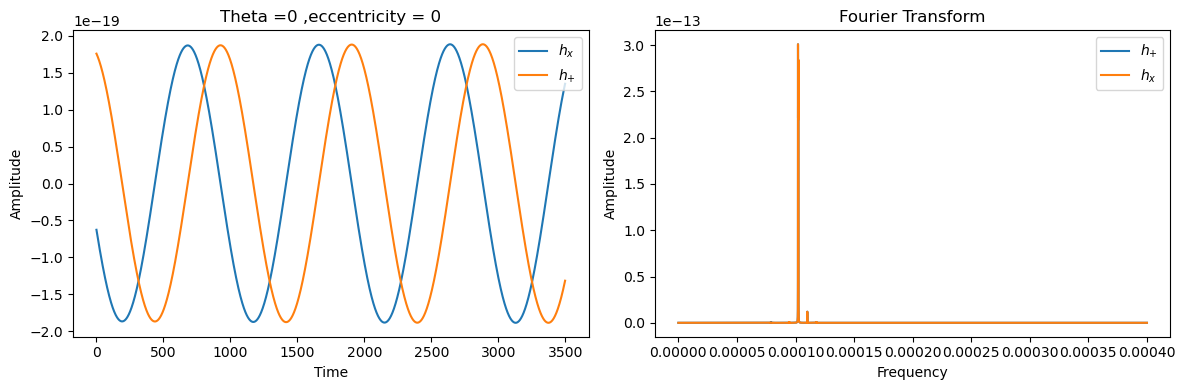

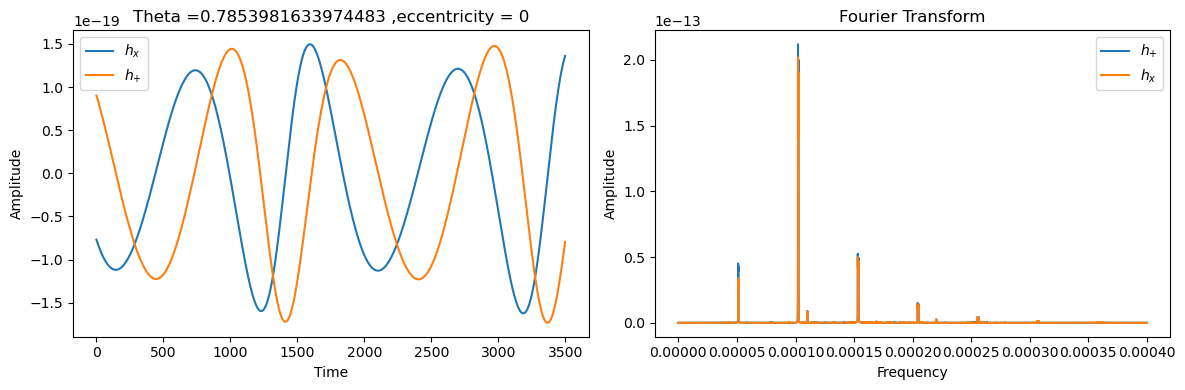

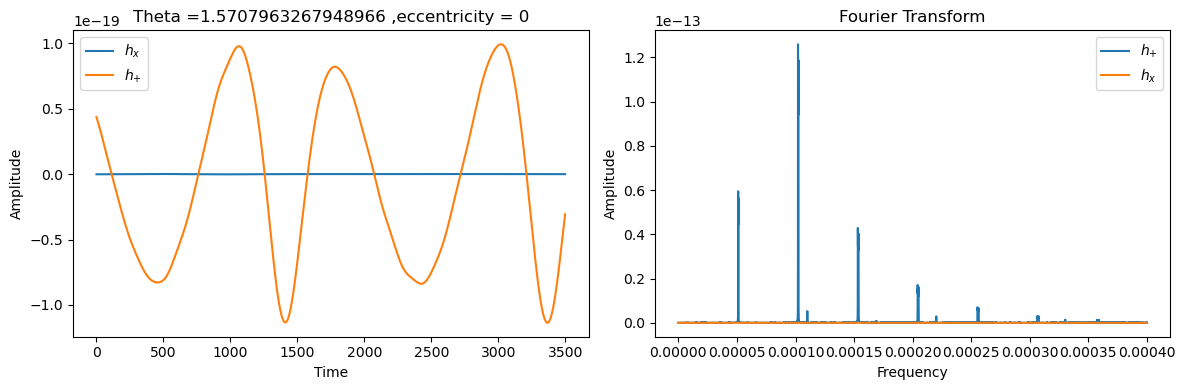

In [ ]:
# an array with 1/365,0.5,1
years = [1/365,0.5,1]
for i in years:
    print(i)
    eccentricitiesdependence(0,6.15,i)

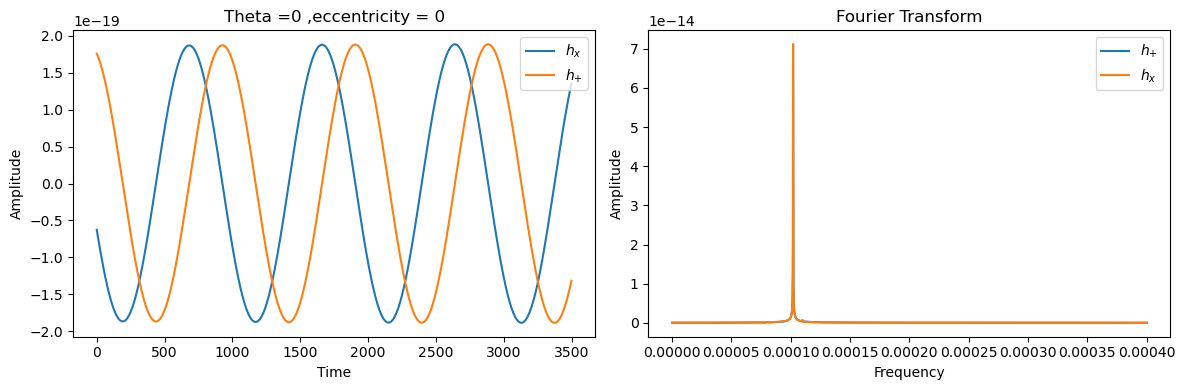

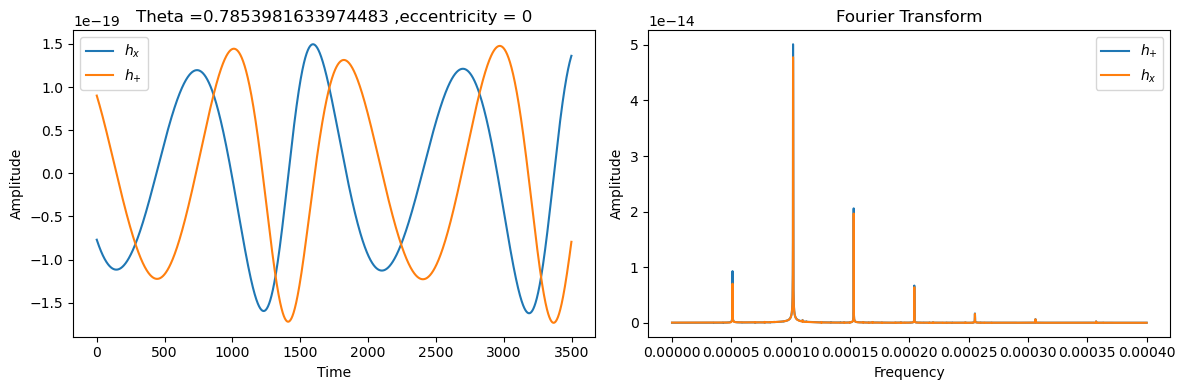

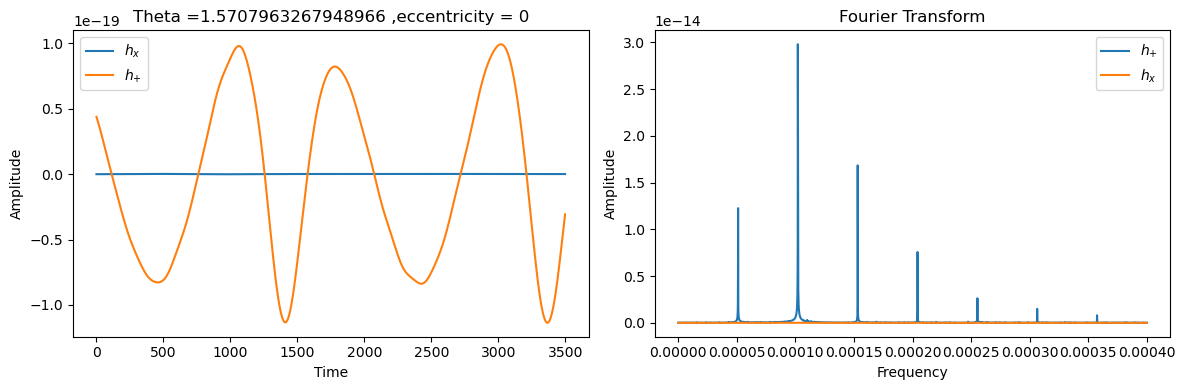

In [22]:
eccentricitiesdependence(0,6.15,12/365)


In [ ]:
for p0 in [9,16,15]:
    print("value of p0 is ",p0)
    for e0 in [0,0.1,0.2,0.3,0.4]:
        print("value of e0 is ",e0)
        eccentricitiesdependence(e0,p0)


value of p0 is  9
value of e0 is  0


TypeError: eccentricitiesdependence() missing 1 required positional argument: 'T'

In [38]:
wave = few(M, mu, 6.15, 0, theta, phi, dist=dist1, dt=dt, T=15/(365)) # generate the waveform
# size of wave


def limit_freq2(freq, fft_data,limit):
    # # # Limit to 0.1 MHz (100 kHz)
# limit_frequency = 1  # 0.1 MHz = 100,000 Hz
# limited_frequencies = frequencies < limit_frequency
# frequencies = frequencies[limited_frequencies]
# H_f = H_f[limited_frequencies]
# positive_frequencies = frequencies > 0
# frequencies = frequencies[positive_frequencies]
# H_f = H_f[positive_frequencies]
    
    positive_frequencies = freq > 0
    freq = freq[positive_frequencies]
    fft_data = fft_data[positive_frequencies]
    limited_frequencies = freq < limit
    freq = freq[limited_frequencies]
    fft_data = fft_data[limited_frequencies]
    return freq, fft_data





def eccentricitiesdependence2(e0m,p0,T):
    # # I want a set of plot for variing theta  with same eccentricity then plot the fourier transform by its side  
    # # Define eccentricities
    dt=1
    # eccentricities = np.linspace(0, 0.4, 5

    # Define eccentricity
    eccentricity = e0m

    # Define theta values
    theta_values = [0,  np.pi/4, np.pi/2]

    # Define Fourier transform function



    # Generate plots for each theta value
    for theta in theta_values:
        # Generate data for the plot
        t= np.arange(len(wave)) * dt  # time array

        # data = np.sin(2 * np.pi * t + theta)
        data = few(M, mu, p0, e0m, theta, phi, dist=dist1, dt=dt, T=T).real.get()
        datax = few(M, mu, p0, e0m, theta, phi, dist=dist1, dt=dt, T=T).imag.get()
        N=len(data)
        # Calculate Fourier transform
        dt= t[1] - t[0] 
        freq, fft_data = fourier_transform(data)
        freqx, fft_datax = fourier_transform(datax)

        # Plot the data and Fourier transform
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.plot( datax[:3500], label=r'$ h_{x} $')
        ax1.plot( data[:3500], label=r'$ h_{+} $')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Amplitude')
        ax1.set_title(f'Theta ={theta:} ,eccentricity = {e0m:}')
        ax1.legend()
        # Plot only the positive frequencies up to the x value of 0.1
        d1,d2=limit_freq2(freq, fft_data,0.004 )
        d1x,d2x=limit_freq2(freqx, fft_datax,0.004)
        ax2.plot(d1, np.abs(d2) , label=r'$ h_{+} $')
        ax2.plot(d1x, np.abs(d2x), label=r'$ h_{x} $' )
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Amplitude')
        ax2.set_title('Fourier Transform')

        ax2.legend()
        plt.tight_layout()
        plt.show()

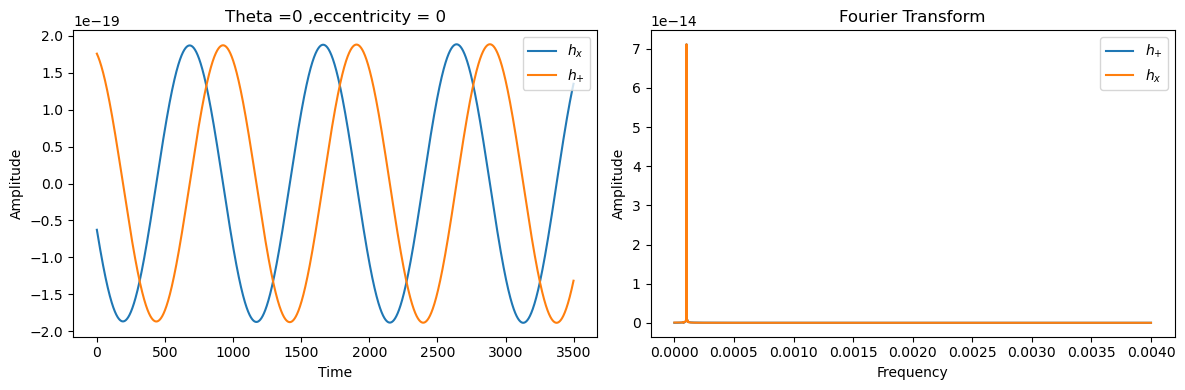

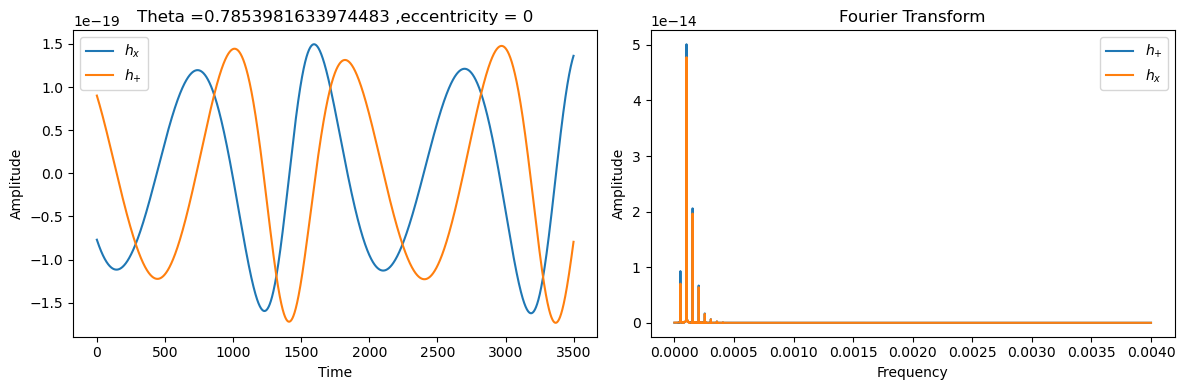

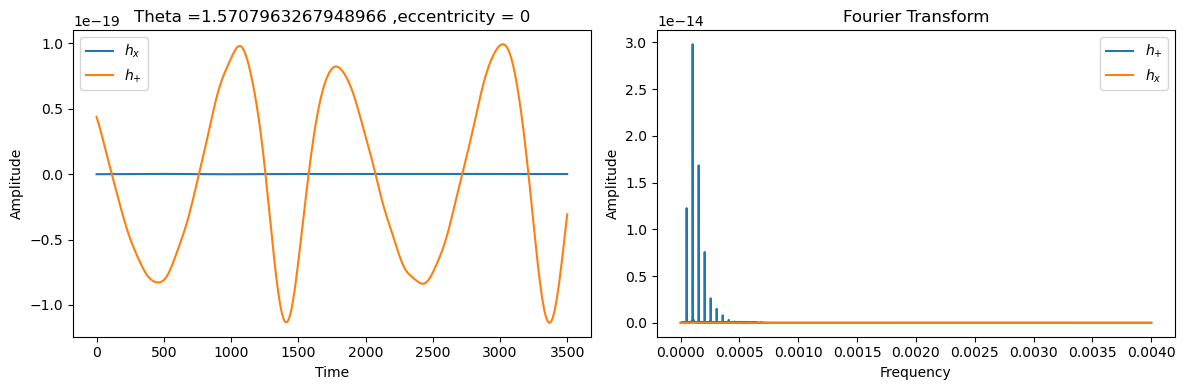

In [39]:
# find the maxima of the fourier transform
def find_maxima(data):
    # Find the maximum value of the data
    max_value = np.max(data)
    # Find the index of the maximum value
    max_index = np.argmax(data)
    return max_value, max_index
t= np.arange(len(wave)) * dt  # time array

        # data = np.sin(2 * np.pi * t + theta)
data = few(M, mu, p0, e0m, theta, phi, dist=dist1, dt=dt, T=T).real.get()
datax = few(M, mu, p0, e0m, theta, phi, dist=dist1, dt=dt, T=T).imag.get()
N=len(data)
# Calculate Fourier transform
dt= t[1] - t[0] 
freq, fft_data = fourier_transform(data)
freqx, fft_datax = fourier_transform(datax)



In [30]:
wave = few(M, mu, 6.15, 0, theta, phi, dist=dist1, dt=dt, T=1/(365*24)) 
# fourier_transform(wave.real.get())
plot2 = fourier_transform(wave.real.get())
plot2[0].size


361

In [49]:
def find_maxima(data):
    # Find the maximum value of the data
    max_value = np.max(data)
    # Find the index of the maximum value
    max_index = np.argmax(data)
    return max_value, max_index
t= np.arange(len(wave)) * dt  # time array

        # data = np.sin(2 * np.pi * t + theta)
data = few(M, mu, p0, 0, theta, phi, dist=dist1, dt=dt, T=T).real.get()
datax = few(M, mu, p0, 0, theta, phi, dist=dist1, dt=dt, T=T).imag.get()
N=len(data)
# Calculate Fourier transform
dt= t[1] - t[0] 
freq, fft_data = fourier_transform(data)
freqx, fft_datax = fourier_transform(datax)
print(find_maxima(freq))

(0.04986149584487535, 180)
